# Using `eat` for thermosensitivity analysis: Synthetic data

The first examples uses synthetic (i.e. fake) to illustrate a typical thermo-sensitivity analysis.

In [1]:
import matplotlib.pyplot as plt
from energy_analysis_toolbox.synthetic import DateSynthTSConsumption

In [2]:
my_synthtisor = DateSynthTSConsumption(
    base_energy=1e3,
    ts_cool=5e1,
    ts_heat=1e2,
    noise_std=1e2,
    t_ref_cool=24,
    t_ref_heat=16,
)

data = my_synthtisor.random_consumption(start="2021-09-01", end="2024-04-17", size=None)

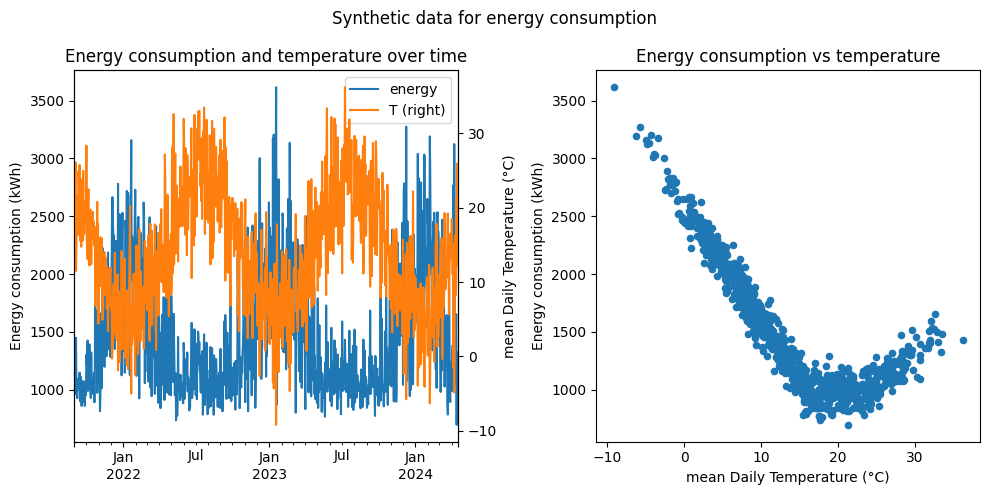

In [3]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
data[["energy"]].plot(ax=ax1)
data[["T"]].plot(ax=ax1, secondary_y=True)
ax1.set_ylabel("Energy consumption (kWh)")
ax1.right_ax.set_ylabel("mean Daily Temperature (°C)")

data.plot.scatter(x="T", y="energy", ax=ax2)
ax2.set_xlabel("mean Daily Temperature (°C)")
ax2.set_ylabel("Energy consumption (kWh)")
ax1.set_title("Energy consumption and temperature over time")
ax2.set_title("Energy consumption vs temperature")
fig.suptitle("Synthetic data for energy consumption")
fig.tight_layout()

# Thermo-sensitivity analysis

The main objective of the analysis is to explain the impact of the temperature over the energy.
In the case of the synthetic model, it relates to
- finding the threshold temperatures for heating and cooling
- finding the three coefficients $E_0$, $TS_{cooling}$ and $TS_{heating}$ such that
    $$ E = E_0 + TS_{cooling} * DD_{cooling}  + TS_{heating} * DD_{heating} $$ 

In [4]:
import pandas as pd
from energy_analysis_toolbox.weather.degree_days import dd_compute

In [5]:
dd_heating = dd_compute(data["T"], reference=16, type="heating", method="mean")
dd_cooling = dd_compute(data["T"], reference=24, type="cooling", method="mean")
data_with_dd = pd.concat([data, dd_heating, dd_cooling], axis=1)
data_with_dd

,base,thermosensitive,residual,energy,heating,...,T,DD_heating,DD_cooling,heating_degree_days,cooling_degree_days
2021-09-01,1000.0,0.000000,161.687440,1161.687440,0.000000,...,23.224711,0.000000,0.000000,0.000000,0.000000
2021-09-02,1000.0,0.000000,13.102712,1013.102712,0.000000,...,16.387722,0.000000,0.000000,0.000000,0.000000
2021-09-03,1000.0,61.223187,-100.234398,960.988789,0.000000,...,25.224464,0.000000,1.224464,0.000000,1.224464
2021-09-04,1000.0,102.883927,-10.972745,1091.911181,0.000000,...,26.057679,0.000000,2.057679,0.000000,2.057679
2021-09-05,1000.0,451.955698,-3.561074,1448.394624,451.955698,...,11.480443,4.519557,0.000000,4.519557,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2024-04-13,1000.0,0.000000,-304.763257,695.236743,0.000000,...,21.235867,0.000000,0.000000,0.000000,0.000000
2024-04-14,1000.0,387.612615,-61.604903,1326.007713,387.612615,...,12.123874,3.876126,0.000000,3.876126,0.000000
2024-04-15,1000.0,95.981166,102.534803,1198.515969,0.000000,...,25.919623,0.000000,1.919623,0.000000,1.919623
2024-04-16,1000.0,114.349285,-31.728673,1082.620613,114.349285,...,14.856507,1.143493,0.000000,1.143493,0.000000


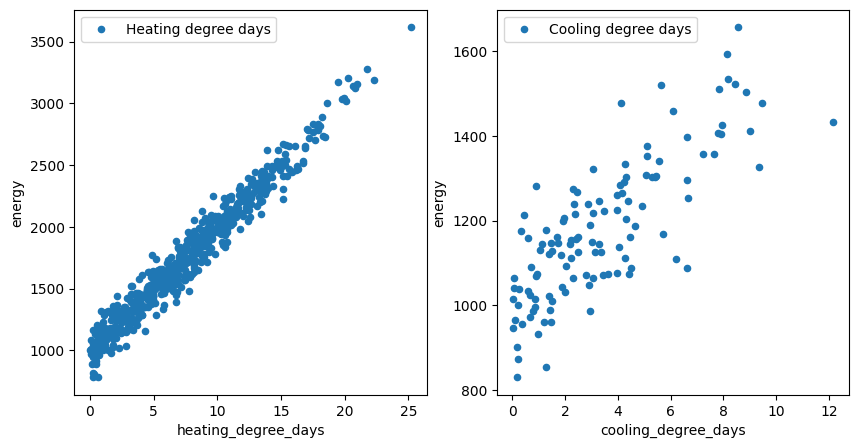

In [6]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
data_with_dd[data_with_dd["heating_degree_days"] > 0].plot.scatter(
    x="heating_degree_days", y="energy", label="Heating degree days", ax=ax1
)
data_with_dd[data_with_dd["cooling_degree_days"] > 0].plot.scatter(
    x="cooling_degree_days", y="energy", ax=ax2, label="Cooling degree days"
);

# Automatic calibration of the degree days model

The degree days are computed relative to a reference (aka base) temperature.

This reference temperature corresponds to the temperature below (resp. above) which the heating (resp. cooling) is required. 
Hence, it depends on the building and the heating/cooling system.

Accordingly, the reference temperature is a parameter to be calibrated from the energy signature of the building.

In [7]:
from energy_analysis_toolbox.thermosensitivity import ThermoSensitivity

In [8]:
data.head()

,base,thermosensitive,residual,energy,heating,cooling,T,DD_heating,DD_cooling
2021-09-01,1000.0,0.000000,161.687440,1161.687440,0.000000,0.000000,23.224711,0.000000,0.000000
2021-09-02,1000.0,0.000000,13.102712,1013.102712,0.000000,0.000000,16.387722,0.000000,0.000000
2021-09-03,1000.0,61.223187,-100.234398,960.988789,0.000000,61.223187,25.224464,0.000000,1.224464
2021-09-04,1000.0,102.883927,-10.972745,1091.911181,0.000000,102.883927,26.057679,0.000000,2.057679
2021-09-05,1000.0,451.955698,-3.561074,1448.394624,451.955698,0.000000,11.480443,4.519557,0.000000


In [9]:
my_synthtisor = DateSynthTSConsumption(
    base_energy=1e3,
    ts_cool=5e1,
    ts_heat=1e2,
    noise_std=1e2,
    t_ref_cool=24,
    t_ref_heat=16,
)

data = my_synthtisor.random_consumption(start="2021-09-01", end="2024-04-17", size=None)

ts = ThermoSensitivity(
    energy_data=data["energy"],
    temperature_data=data["T"],
    frequency="1D",
    degree_days_type="both",
    degree_days_computation_method="mean",  # here the provided data is already in daily frequency. Hence the only mean
)

In [10]:
ts.calibrate_base_temperatures(xatol=1e-1, disp=True)

t0=13.8197, 15767.87, 295799.26
t0=16.1803, 10470.61, 295799.26
t0=17.6393, 12380.12, 295799.26
t0=16.2137, 10487.09, 295799.26
t0=15.7646, 10471.92, 295799.26
t0=16.0215, 10424.92, 295799.26
t0=15.9739, 10422.78, 295799.26
t0=15.9405, 10423.98, 295799.26

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  0.1 )
t0=23.8197, 9776.37, 28378.26
t0=26.1803, 12393.81, 28378.26
t0=22.3607, 9939.09, 28378.26
t0=23.2647, 9690.19, 28378.26
t0=23.2981, 9689.96, 28378.26
t0=23.3314, 9690.53, 28378.26

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  0.1 )


## Fitting thermo-sensitivity model

using the newlly computed degree days, we can fit the thermo-sensitivity model to the energy consumption.

In [11]:
ts.fit()
ts.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                 1.266e+04
Date:                Fri, 11 Oct 2024   Prob (F-statistic):               0.00
Time:                        20:46:09   Log-Likelihood:                -5793.0
No. Observations:                 960   AIC:                         1.159e+04
Df Residuals:                     957   BIC:                         1.161e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
heating_degree_days   101.0069      0.640    157.815      0.000      99.751     102.263
cooling_degree_days    48.4614      2.057     23.554      0.000      44.424      52.499
Intercept             986.7006      4.709    209.553      0.000     977.460     995.941
==============================================================================
Omnibus:                        1.113   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.573   Jarque-Bera (JB):                1.180
Skew:                          -0.077   Prob(JB):                        0.554
Kurtosis:                       2.926   Cond. No.                         10.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

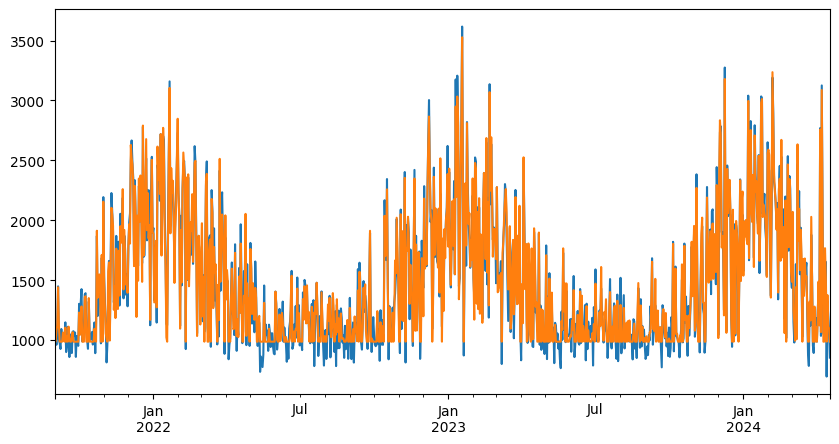

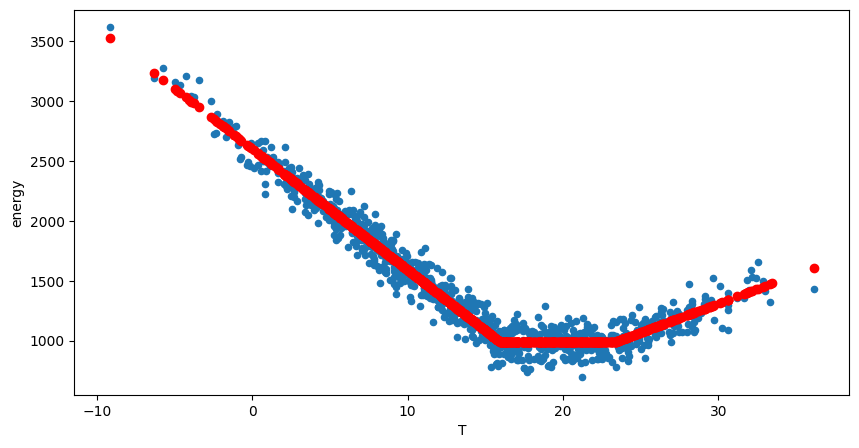

In [12]:
pred = ts.model.predict()

fig, ax = plt.subplots(figsize=(10, 5))
data["energy"].plot(ax=ax, label="Observed")
ax.plot(data.index, pred, label="Predicted")

fig, ax = plt.subplots(figsize=(10, 5))
data.plot.scatter(x="T", y="energy", ax=ax)
ax.scatter(data["T"], ts.model.predict(), label="Predicted", color="r");

## Accessing the performance of the calibration

The performance of the calibration is assessed by the obtained value with respect to the actual reference temperature used to generate the synthetic data.

We recall that the synthetic data is generated using the following formula
$$ E = E_0 + TS_{heating} * DD_{heating} + \mathcal{N}(0, \sigma)$$ 



In [13]:
n_test = 500
results = []
my_synthtisor = DateSynthTSConsumption(
    base_energy=1e3,
    ts_cool=5e1,
    ts_heat=1e2,
    noise_std=1e2,
    t_ref_cool=24,
    t_ref_heat=16,
)
for idx in range(n_test):
    data = my_synthtisor.random_consumption(start="2021-09-01", end=None, size=200)
    ts = ThermoSensitivity(
        energy_data=data["energy"],
        temperature_data=data["T"],
        frequency="1D",
    )
    ts.degree_days_computation_method = "mean"
    tref = ts.calibrate_base_temperature(
        dd_type="heating", t0=13, xatol=1e-2, disp=False
    )
    results.append(tref)

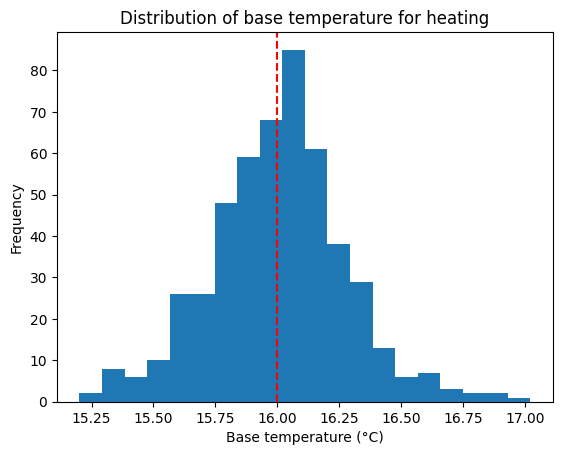

In [14]:
fig, ax = plt.subplots()
ax.hist(results, bins=20)
ax.set_xlabel("Base temperature (°C)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of base temperature for heating")
ax.axvline(
    x=my_synthtisor.t_ref_heat, color="r", linestyle="--", label="True base temperature"
)

# Automatic detection of the type of thermo sensitivity

In general, it is difficult to know in advance the type of thermo-sensitivity of a building. 
By "type" I mean : does the building heat during cold days or cool during hot days, or both ?

Hence, it is important to be able to detect it automatically.

By setting the type to `"auto"`, the model will try to detect the type of thermo-sensitivity using Spearman correlation p-value.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                 1.328e+04
Date:                Fri, 11 Oct 2024   Prob (F-statistic):               0.00
Time:                        20:46:28   Log-Likelihood:                -3583.2
No. Observations:                 960   AIC:                             7172.
Df Residuals:                     957   BIC:                             7187.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
heating_degree_days    10.0768      0.065    155.803      0.000       9.950      10.204
cooling_degree_days     0.3656      0.177      2.063      0.039       0.018       0.713
Intercept             998.9269      0.481   2076.770      0.000     997.983     999.871
==============================================================================
Omnibus:                        1.366   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.505   Jarque-Bera (JB):                1.415
Skew:                          -0.089   Prob(JB):                        0.493
Kurtosis:                       2.942   Cond. No.                         10.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

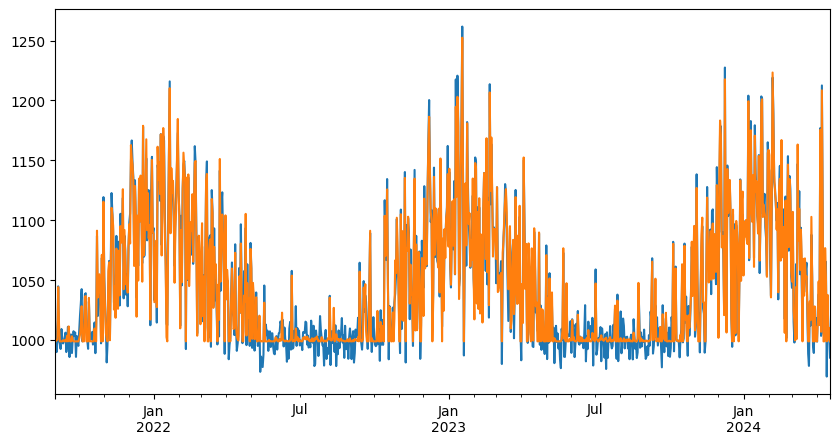

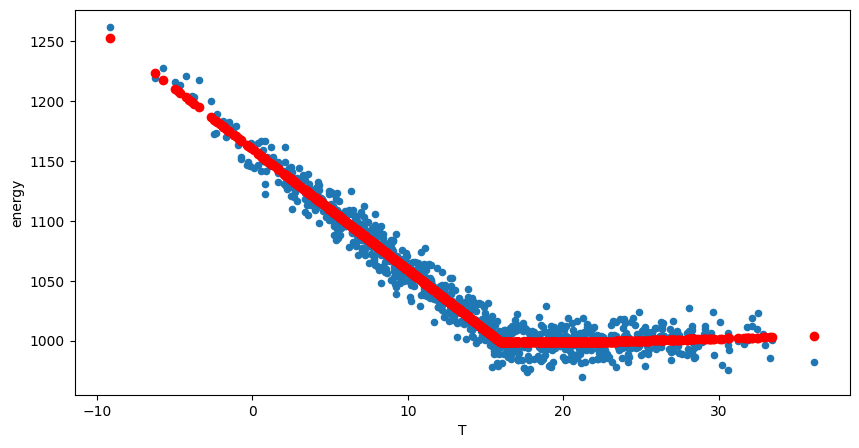

In [15]:
my_synthtisor_heating = DateSynthTSConsumption(
    base_energy=1e3,
    ts_cool=0,
    ts_heat=1e1,
    noise_std=1e1,
    t_ref_cool=24,
    t_ref_heat=16,
    noise_seed=42,
)

data = my_synthtisor_heating.random_consumption(
    start="2021-09-01", end="2024-04-17", size=None
)

ts = ThermoSensitivity(
    energy_data=data["energy"],
    temperature_data=data["T"],
    frequency="1D",
    degree_days_type="auto",
    degree_days_computation_method="mean",
)
ts.fit()
display(ts.model.summary())

pred = ts.model.predict()

fig, ax = plt.subplots(figsize=(10, 5))
data["energy"].plot(ax=ax, label="Observed")
ax.plot(data.index, pred, label="Predicted")

fig, ax = plt.subplots(figsize=(10, 5))
data.plot.scatter(x="T", y="energy", ax=ax)
ax.scatter(data["T"], ts.model.predict(), label="Predicted", color="r")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     40.55
Date:                Fri, 11 Oct 2024   Prob (F-statistic):           2.97e-10
Time:                        20:46:28   Log-Likelihood:                -5793.5
No. Observations:                 960   AIC:                         1.159e+04
Df Residuals:                     958   BIC:                         1.160e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
cooling_degree_days    11.1431      1.750      6.368      0.000       7.709      14.577
Intercept             990.8276      3.456    286.736      0.000     984.046     997.609
==============================================================================
Omnibus:                        1.330   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.514   Jarque-Bera (JB):                1.393
Skew:                          -0.086   Prob(JB):                        0.498
Kurtosis:                       2.928   Cond. No.                         2.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

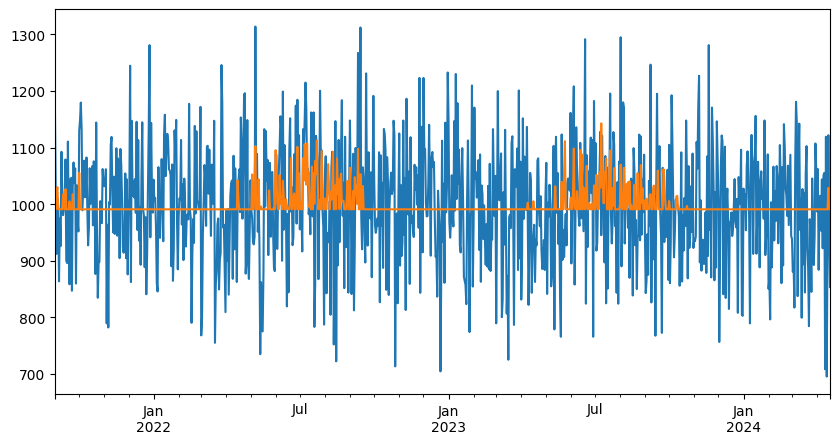

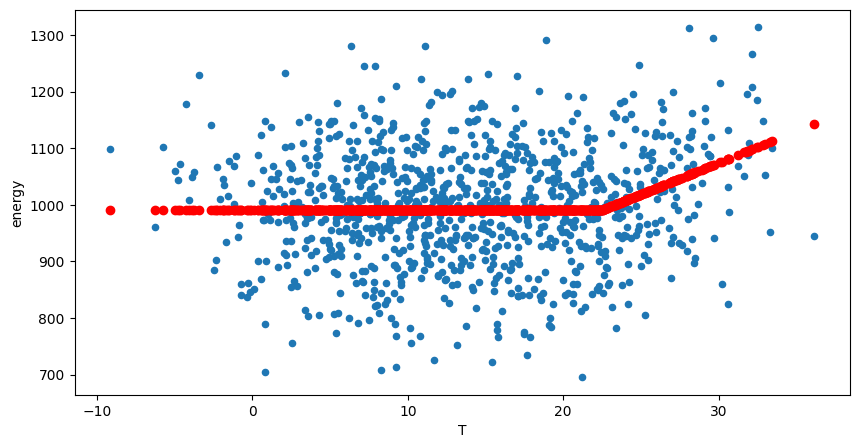

In [16]:
my_synthtisor_cooling = DateSynthTSConsumption(
    base_energy=1e3,
    ts_cool=1e1,
    ts_heat=0,
    noise_std=1e2,
    t_ref_cool=24,
    t_ref_heat=16,
)

data = my_synthtisor_cooling.random_consumption(
    start="2021-09-01", end="2024-04-17", size=None
)

ts = ThermoSensitivity(
    energy_data=data["energy"],
    temperature_data=data["T"],
    frequency="1D",
    degree_days_type="auto",
    degree_days_computation_method="mean",
)
ts.fit()
display(ts.model.summary())

pred = ts.model.predict()

fig, ax = plt.subplots(figsize=(10, 5))
data["energy"].plot(ax=ax, label="Observed")
ax.plot(data.index, pred, label="Predicted")

fig, ax = plt.subplots(figsize=(10, 5))
data.plot.scatter(x="T", y="energy", ax=ax)
ax.scatter(data["T"], ts.model.predict(), label="Predicted", color="r")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     47.26
Date:                Fri, 11 Oct 2024   Prob (F-statistic):           2.67e-20
Time:                        20:46:29   Log-Likelihood:                -5792.9
No. Observations:                 960   AIC:                         1.159e+04
Df Residuals:                     957   BIC:                         1.161e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
heating_degree_days     5.7894      0.651      8.889      0.000       4.511       7.067
cooling_degree_days    11.6883      1.831      6.383      0.000       8.095      15.282
Intercept             987.5312      4.754    207.732      0.000     978.202     996.860
==============================================================================
Omnibus:                        1.281   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.527   Jarque-Bera (JB):                1.339
Skew:                          -0.085   Prob(JB):                        0.512
Kurtosis:                       2.935   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

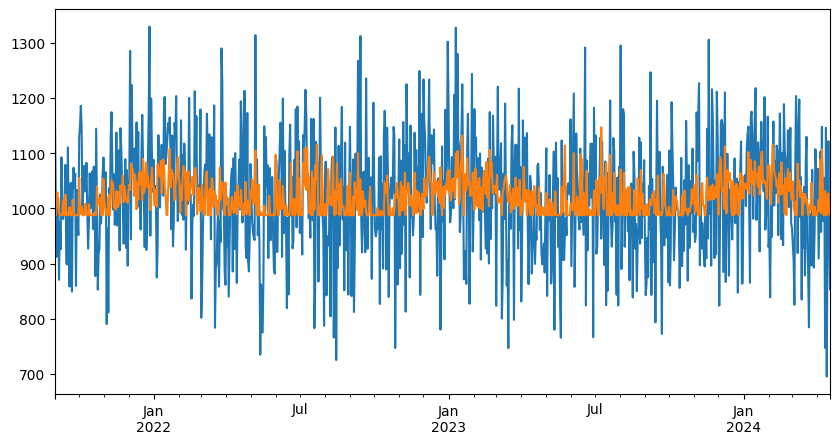

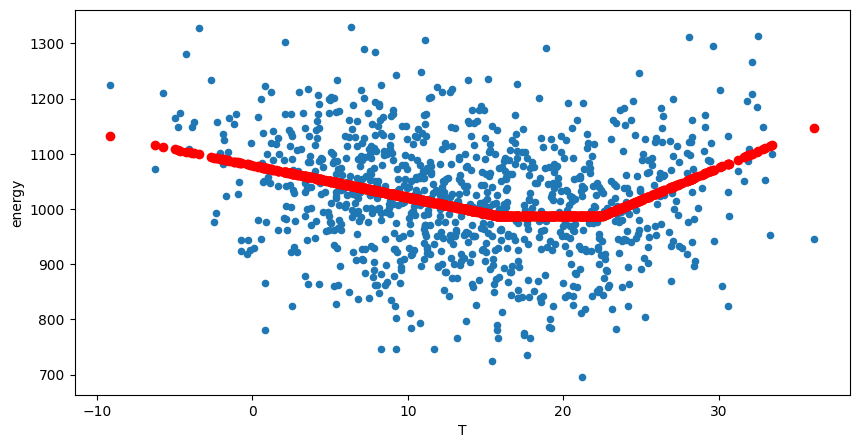

In [17]:
my_synthtisor_both = DateSynthTSConsumption(
    base_energy=1e3,
    ts_cool=1e1,
    ts_heat=5e0,
    noise_std=1e2,
    t_ref_cool=24,
    t_ref_heat=16,
)

data = my_synthtisor_both.random_consumption(start="2021-09-01", end="2024-04-17", size=None)

ts = ThermoSensitivity(
    energy_data=data["energy"],
    temperature_data=data["T"],
    frequency="1D",
    degree_days_type="auto",
    degree_days_computation_method="mean",
)
ts.fit()
display(ts.model.summary())

pred = ts.model.predict()

fig, ax = plt.subplots(figsize=(10, 5))
data["energy"].plot(ax=ax, label="Observed")
ax.plot(data.index, pred, label="Predicted")

fig, ax = plt.subplots(figsize=(10, 5))
data.plot.scatter(x="T", y="energy", ax=ax)
ax.scatter(data["T"], ts.model.predict(), label="Predicted", color="r");

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.827
Date:                Fri, 11 Oct 2024   Prob (F-statistic):             0.0507
Time:                        20:46:29   Log-Likelihood:                -1373.1
No. Observations:                 960   AIC:                             2750.
Df Residuals:                     958   BIC:                             2760.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
cooling_degree_days     0.0330      0.017      1.956      0.051      -0.000       0.066
Intercept             999.9146      0.035   2.88e+04      0.000     999.847     999.983
==============================================================================
Omnibus:                        1.427   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.490   Jarque-Bera (JB):                1.483
Skew:                          -0.091   Prob(JB):                        0.476
Kurtosis:                       2.935   Cond. No.                         2.25
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

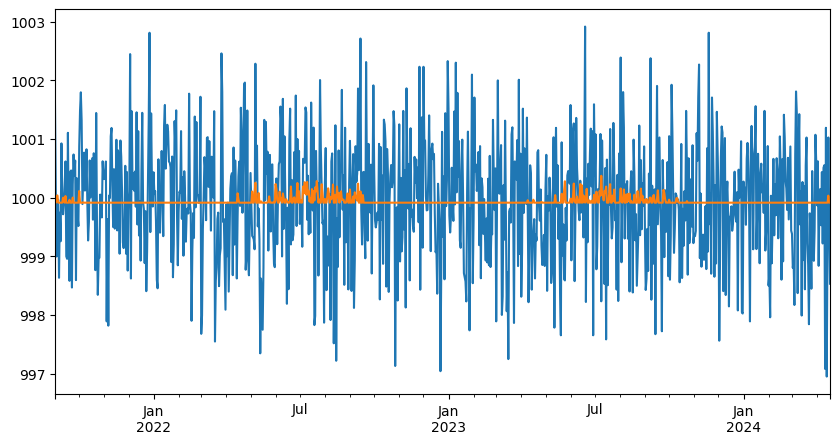

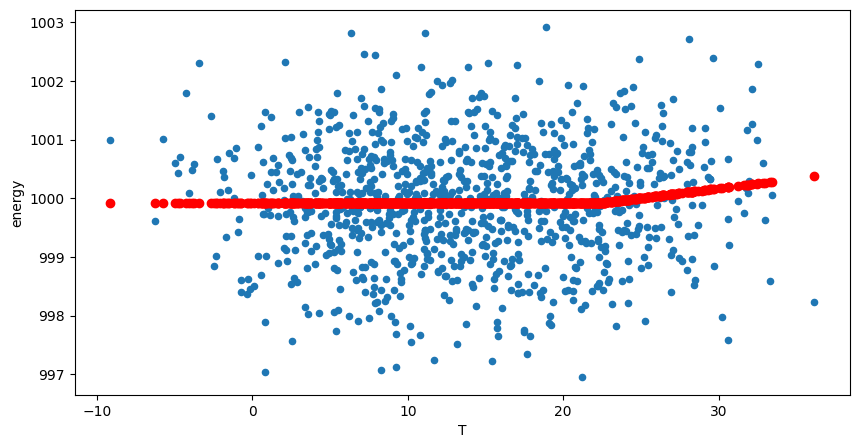

In [18]:
my_synthtisor_both = DateSynthTSConsumption(
    base_energy=1e3,
    ts_cool=0,
    ts_heat=0,
    noise_std=1e0,
    t_ref_cool=24,
    t_ref_heat=16,
)

data = my_synthtisor_both.random_consumption(start="2021-09-01", end="2024-04-17", size=None)

ts = ThermoSensitivity(
    energy_data=data["energy"],
    temperature_data=data["T"],
    frequency="1D",
    degree_days_type="auto",
    degree_days_computation_method="mean",
)
ts.fit()
display(ts.model.summary())

pred = ts.model.predict()

fig, ax = plt.subplots(figsize=(10, 5))
data["energy"].plot(ax=ax, label="Observed")
ax.plot(data.index, pred, label="Predicted")

fig, ax = plt.subplots(figsize=(10, 5))
data.plot.scatter(x="T", y="energy", ax=ax)
ax.scatter(data["T"], ts.model.predict(), label="Predicted", color="r");

In [19]:
ts

ThermoSensitivity(frequency=1D,
        degree_days_type=cooling,
        degree_days_base_temperature={'heating': np.float64(15.8), 'cooling': np.float64(22.29)},
        degree_days_computation_method=mean,
        interseason_mean_temperature=20)

                            OLS Regression Results                            
Dep. Variable:                 energy   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
No. Observations:                 960   F-statistic:                     3.827
Covariance Type:            nonrobust   Prob (F-statistic):             0.0507
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
cooling_degree_days     0.0330      0.017      1.956      0.051      -0.000       0.066
Intercept             999.9146      0.035   2.88e+04      0.000     999.847     999.983

N

# Conclusion

We showed in the notebook how to calibrate the degree days reference temperatures and the thermo-sensitivity model using the synthetic data.

We showed that the calibration is possible and that the performance is reasonable.

## Implemented features

- automatic detection of the type of thermo-sensitivity (Heating, Cooling, Mixed), even in the presence of noise.
- automatic calibration of the degree days reference temperature (heating and cooling)
- automatic calibration of the thermo-sensitivity model (heating and cooling)

## Discussion

To continue the analysis, we could study the impact of the noise level on the calibration performance, usually named Uncertainty Quantification (UQ).

Most of the calibration uses a "intersaison mean temperature" to split the data into heating and cooling periods. By default this value of $20^\circ C$.
It would be interesting to study the impact of this value on the calibration performance.

# Categorical thermo-sensitivity

One of the difficulties of the thermo-sensitivity analysis is the fact that the building behavior can change depending on the day µ(open/closed, week/weekend, holiday, etc).

The following example shows how to use the categorical thermo-sensitivity to model the behavior of a building depending on the day of the week.

In [20]:
from energy_analysis_toolbox.synthetic.thermosensitive_consumption import WeekEndSynthTSConsumption

parameters = [
    {
        "base_energy": 1e3,
        "ts_heat": 5e1,
        "ts_cool": 1e2,
        "noise_std": 1e2,
    },
    {
        "base_energy": 1.5e3,
        "ts_heat": 1e1,
        "ts_cool": 6e1,
        "noise_std": 1e2,
    },
]


def open_close_categoriser(series: pd.Series):
    """Return a series of categories based on the day of the week of the index"""
    timestamps = series.index
    return_data = pd.Series(
        data=[
            "Open" if timestamp.weekday() < 5 else "Closed" for timestamp in timestamps
        ],
        index=series.index,
    )
    return return_data


my_cat_synthtisor = WeekEndSynthTSConsumption(
    parameters=parameters,
    t_ref_cool=24,
    t_ref_heat=16,
)
data = my_cat_synthtisor.random_consumption(start="2021-09-01", end="2024-04-17", size=None)
data.head()

,base,thermosensitive,residual,energy,heating,cooling,T,DD_heating,DD_cooling,category
2021-09-01,1500.0,0.000000,30.471708,1530.471708,0.000000,0.000000,23.224711,0.000000,0.000000,weekday
2021-09-02,1500.0,0.000000,-103.998411,1396.001589,0.000000,0.000000,16.387722,0.000000,0.000000,weekday
2021-09-03,1500.0,73.467824,75.045120,1648.512944,0.000000,73.467824,25.224464,0.000000,1.224464,weekday
2021-09-04,1000.0,205.767853,30.471708,1236.239561,0.000000,205.767853,26.057679,0.000000,2.057679,weekend
2021-09-05,1000.0,225.977849,-103.998411,1121.979438,225.977849,0.000000,11.480443,4.519557,0.000000,weekend


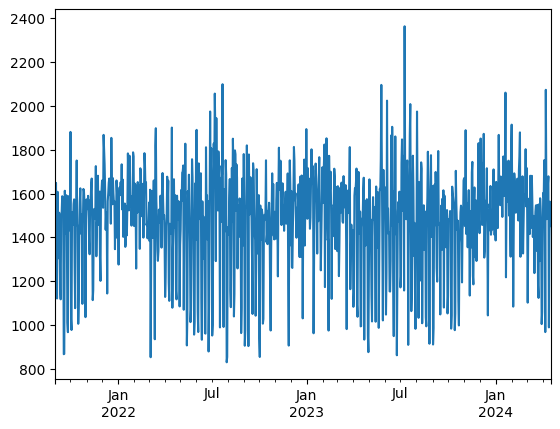

In [21]:
data["energy"].plot();

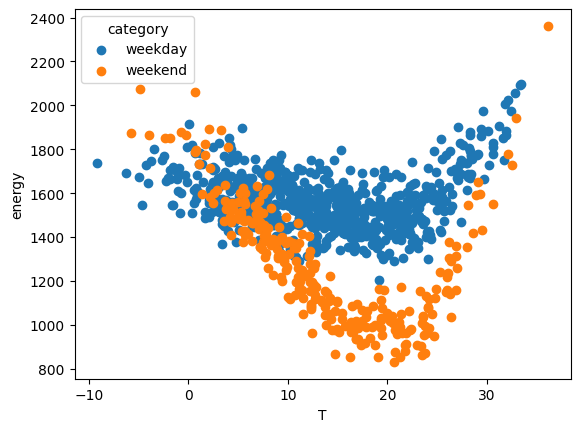

In [22]:
categories = data["category"].unique()
for category in categories:
    subset = data[data["category"] == category]
    plt.scatter(
        subset["T"],
        subset["energy"],
        label=category
    )
plt.xlabel("T")
plt.ylabel("energy")
plt.legend(title="category")
plt.show()

## Using no category

As a first step, we can consider that the building has no category and that the behavior is the same every day.

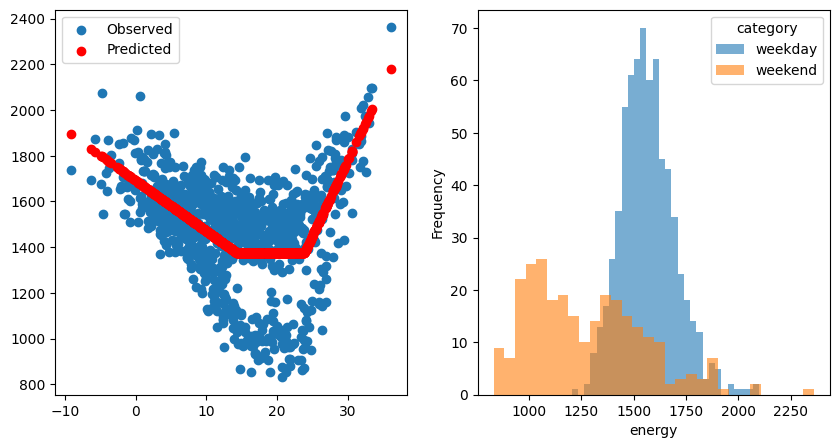

In [23]:
ts_no_cat = ThermoSensitivity(
    energy_data=data["energy"],
    temperature_data=data["T"],
    frequency="1D",
    degree_days_type="auto",
    degree_days_computation_method="mean",
)
ts_no_cat.fit()
# display(ts_no_cat.model.summary())
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(data["T"], data["energy"], label="Observed")
ax1.scatter(data["T"], ts_no_cat.model.predict(), label="Predicted", color="r")
ax1.legend()

error = data["energy"] - ts_no_cat.model.predict()
error = pd.concat([error, data["category"]], axis=1)

categories = data["category"].unique()

for category in categories:
    subset = data[data["category"] == category]
    ax2.hist(
        subset["energy"],
        bins=30,
        alpha=0.6,
        label=category,
        density=False,
    )
ax2.set_xlabel("energy")
ax2.set_ylabel('Frequency')
ax2.legend(title="category");

## Using Categories

Now, lets consider that the building has two categories: week and weekend (fortunately, we know how the data is generated).


In [24]:
categories = open_close_categoriser(data).rename("category")
categories

2021-09-01      Open
2021-09-02      Open
2021-09-03      Open
2021-09-04    Closed
2021-09-05    Closed
               ...  
2024-04-13    Closed
2024-04-14    Closed
2024-04-15      Open
2024-04-16      Open
2024-04-17      Open
Name: category, Length: 960, dtype: object

In [25]:
from energy_analysis_toolbox.thermosensitivity.thermosensitivity import (
    CategoricalThermoSensitivity,
)

ts_cat = CategoricalThermoSensitivity(
    energy_data=data["energy"],
    temperature_data=data["T"],
    categories=categories,
    frequency="1D",
    degree_days_type="auto",
    degree_days_computation_method="mean",
)
ts_cat.fit()

CategoricalThermoSensitivity(frequency=1D,
        degree_days_type=both,
        degree_days_base_temperature={'heating': np.float64(14.37), 'cooling': np.float64(23.82)},
        degree_days_computation_method=mean,
        interseason_mean_temperature=20)

                            OLS Regression Results                            
Dep. Variable:                 energy   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.813
No. Observations:                 960   F-statistic:                     834.1
Covariance Type:            nonrobust   Prob (F-statistic):               0.00
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
heating_degree_days:Closed    55.4922      1.360     40.816      0.000      52.824      58.160
heating_degree_days:Open      10.7250      0.797     13.454 

In [26]:
ts_cat.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     834.1
Date:                Fri, 11 Oct 2024   Prob (F-statistic):               0.00
Time:                        20:46:30   Log-Likelihood:                -5762.8
No. Observations:                 960   AIC:                         1.154e+04
Df Residuals:                     954   BIC:                         1.157e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
heating_degree_days:Closed    55.4922      1.360     40.816      0.000      52.824      58.160
heating_degree_days:Open      10.7250      0.797     13.454      0.000       9.161      12.289
cooling_degree_days:Closed    93.9007      3.979     23.601      0.000      86.093     101.709
cooling_degree_days:Open      54.1264      2.563     21.118      0.000      49.096      59.156
Intercept:Closed            1025.8751      8.237    124.546      0.000    1009.711    1042.040
Intercept:Open              1504.6139      5.049    297.985      0.000    1494.705    1514.523
==============================================================================
Omnibus:                        3.208   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.201   Jarque-Bera (JB):                3.150
Skew:                           0.140   Prob(JB):                        0.207
Kurtosis:                       3.018   Cond. No.                         13.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

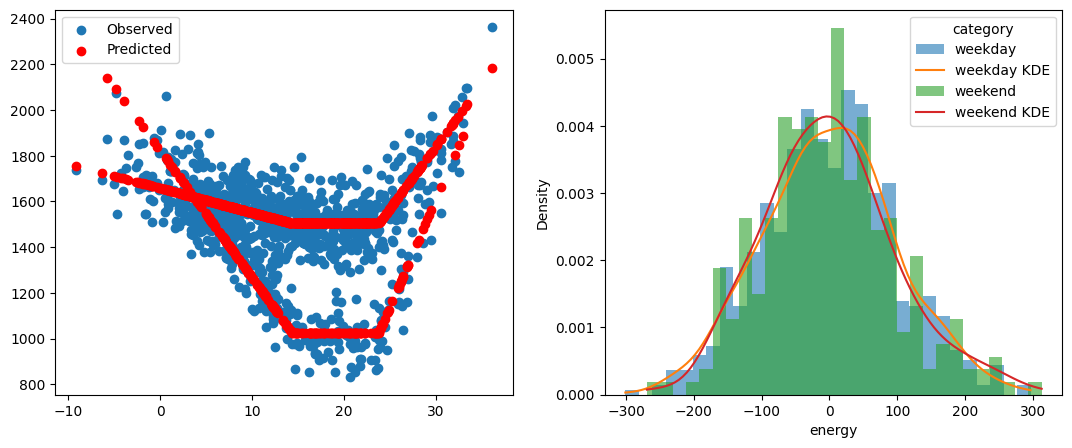

In [27]:
from scipy.stats import gaussian_kde
import numpy as np

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5))
ax1.scatter(data["T"], data["energy"], label="Observed")
ax1.scatter(data["T"], ts_cat.model.predict(), label="Predicted", color="r")
ax1.legend()

error = data["energy"] - ts_cat.model.predict()
error = pd.concat([error, data["category"]], axis=1)

categories = error["category"].unique()

for category in categories:
    subset = error[error["category"] == category]
    ax2.hist(
        subset["energy"],
        bins=30,
        alpha=0.6,
        label=category,
        density=True
    )
    kde_data = gaussian_kde(subset["energy"])
    x_vals = np.linspace(subset["energy"].min(), subset["energy"].max(), 100)
    ax2.plot(x_vals, kde_data(x_vals), label=f'{category} KDE')

ax2.set_xlabel("energy")
ax2.set_ylabel("Density")
ax2.legend(title="category");

# Automatic detection of the category to use

In [28]:
from energy_analysis_toolbox.thermosensitivity.daily_analysis import (
    AutoCategoricalThermoSensitivity,
)

In [29]:
data = data = my_cat_synthtisor.random_consumption(
    start="2021-09-01", end="2024-04-17", size=None
)


ts = AutoCategoricalThermoSensitivity(
    energy_data=data["energy"],
    temperature_data=data["T"],
    degree_days_type="auto",
    degree_days_computation_method="mean",
)

ts.fit()

AutoCategoricalThermoSensitivity(frequency=1D,
        degree_days_type=both,
        degree_days_base_temperature={'heating': np.float64(17.69), 'cooling': np.float64(23.78)},
        degree_days_computation_method=mean,
        interseason_mean_temperature=20)

                            OLS Regression Results                            
Dep. Variable:                 energy   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.814
No. Observations:                 960   F-statistic:                     211.0
Covariance Type:            nonrobust   Prob (F-statistic):               0.00
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
heating_degree_days:Friday       11.3549      1.618      7.018      0.000       8.180      14.530
heating_degree_days:Monday       10.7842      1

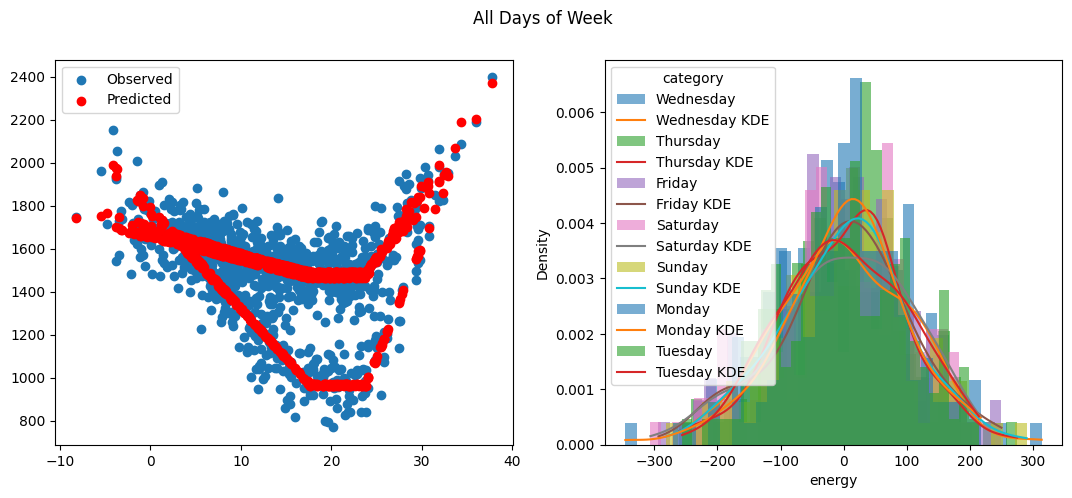

In [30]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5))
ax1.scatter(ts.resampled_temperature, ts.resampled_energy, label="Observed")
ax1.scatter(ts.resampled_temperature, ts.model.predict(), label="Predicted", color="r")
ax1.legend()

error = ts.resampled_energy - ts.model.predict()
error = pd.concat([error, ts.resampled_categories], axis=1)

categories = error["category"].unique()

for category in categories:
    subset = error[error["category"] == category]
    ax2.hist(
        subset["energy"],
        bins=30,
        alpha=0.6,
        label=category,
        density=True
    )
    kde_data = gaussian_kde(subset["energy"])
    x_vals = np.linspace(subset["energy"].min(), subset["energy"].max(), 100)
    ax2.plot(x_vals, kde_data(x_vals), label=f'{category} KDE')

ax2.set_xlabel("energy")
ax2.set_ylabel("Density")
ax2.legend(title="category")

fig.suptitle("All Days of Week");

In [31]:
ts.merge_and_fit()

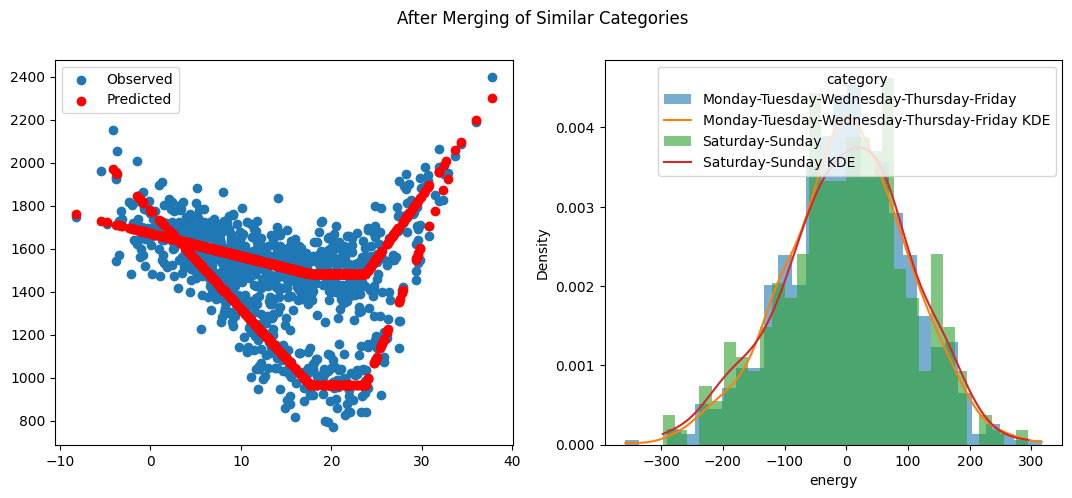

In [32]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5))
ax1.scatter(ts.resampled_temperature, ts.resampled_energy, label="Observed")
ax1.scatter(ts.resampled_temperature, ts.model.predict(), label="Predicted", color="r")
ax1.legend()

error = ts.resampled_energy - ts.model.predict()
error = pd.concat([error, ts.resampled_categories], axis=1)
categories = error["category"].unique()

for category in categories:
    subset = error[error["category"] == category]
    ax2.hist(
        subset["energy"],
        bins=30,
        alpha=0.6,
        label=category,
        density=True
    )

    # KDE
    kde_data = gaussian_kde(subset["energy"])
    x_vals = np.linspace(subset["energy"].min(), subset["energy"].max(), 100)
    ax2.plot(x_vals, kde_data(x_vals), label=f'{category} KDE')

ax2.set_xlabel("energy")
ax2.set_ylabel("Density")
ax2.legend(title="category")
fig.suptitle("After Merging of Similar Categories");

As expected, the days with the same categories are similare. Lets see if the model can capture the difference between the days.

# Conclusion

We have seen how we can analyse the consumption of a building depending even with different thermo-sensitivity depending on the day.

However, we still need to see how the model behaves in the presence of labeling errors. Typically, we could have a day that is labeled as a weekend day but that is actually with a week day behavior.